# Fune tuning stable diffusion model with DreamBooth technique

It is a technique that can update the whole weights of diffusion model with using only a couple of images. These images can teach the model an object or a style.


## Setup

Check the memory size, it should be at least 12GB for this notebook

In [16]:
# GPU check
!nvidia-smi

Wed Jun 26 12:40:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100S-PCIE-32GB          On  |   00000000:00:05.0 Off |                    0 |
| N/A   42C    P0             27W /  250W |       0MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install Diffusers library

In [ ]:
!git clone https://github.com/huggingface/diffusers
%cd diffusers
!pip install .

## Install DreamBooth method requirements

In [ ]:
%cd examples/dreambooth
!pip install -r requirements.txt
!pip install bitsandbytes
!pip install transformers ftfy accelerate

In [ ]:
!pip install --upgrade huggingface-hub

## Datasets

Create a folder for Custom Datasets.
This folder is for preparing the **instance** and **class** images.

In [20]:
import os

if os.path.exists("custom_dataset"):
    print("Removing existing custom_dataset folder")
    !rm -rf custom_dataset

print("Creating new custom_dataset folder")
!mkdir custom_dataset
!mkdir custom_dataset/instance_images

print('Custom Dataset folder is created: custom_dataset')

Creating new custom_dataset folder
Custom Dataset folder is created: custom_dataset


### Utils for dataset preprocessing

- Resize and crop function
- Function to show images in a one row

In [21]:
from PIL import Image
import os
import IPython.display as display
import matplotlib.pyplot as plt

def resize_and_crop_images(folder_path, target_size=512):
    """
    Resize the images in a folder to have a smaller edge of the specified target size and display them.

    Parameters:
    - folder_path (str): Path to the folder containing the images.
    - target_size (int): Desired size for the smaller edge (default is 512).
    """
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is an image
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Open the image
            image = Image.open(file_path)

            # Get the original width and height
            width, height = image.size

            # Calculate the new size while maintaining the aspect ratio
            if width <= height:
                new_width = target_size
                new_height = int(height * (target_size / width))
            else:
                new_width = int(width * (target_size / height))
                new_height = target_size

            # Resize the image
            resized_image = image.resize((new_width, new_height))

            left = (new_width - target_size) // 2
            top = (new_height - target_size) // 2
            right = (new_width + target_size) // 2
            bottom = (new_height + target_size) // 2

            # Perform the center crop
            cropped_image = resized_image.crop((left, top, right, bottom))
            cropped_image.save(file_path)

def show_images_in_one_row(folder_path, target_size=256):
    images = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            img = Image.open(file_path)
            img = img.resize((target_size, int(target_size * img.size[1] / img.size[0])))
            images.append(img)

    # Display images in one row
    fig, axes = plt.subplots(1, len(images), figsize=(len(images) * 3, 3))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

### Instance images

In [22]:
import requests
import os
from tqdm import tqdm  

# GitHub repository URL and path to the folder
base_url = 'https://raw.githubusercontent.com/google/dreambooth/main/dataset/dog2/'

# Local destination directory
destination_dir = 'custom_dataset/instance_images/'

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Fetching file list from GitHub
response = requests.get('https://api.github.com/repos/google/dreambooth/contents/dataset/dog2')
file_list = response.json()

# Download each file in the list
for file in tqdm(file_list):
    if file['type'] == 'file':
        file_url = base_url + file['name']
        file_destination = os.path.join(destination_dir, file['name'])
        response = requests.get(file_url)
        with open(file_destination, 'wb') as f:
            f.write(response.content)

print(f'Downloaded images to {destination_dir}')

100%|██████████| 6/6 [00:00<00:00, 24.79it/s]

Downloaded images to custom_dataset/instance_images/


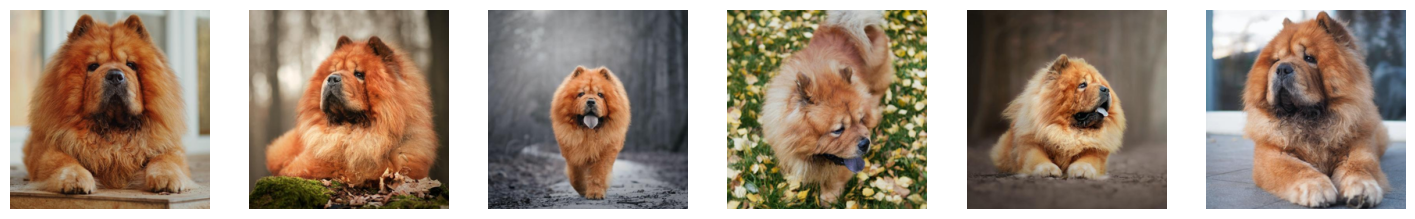

In [23]:
# Resize instance images to 512x512 for diffusion model

folder_path = 'custom_dataset/instance_images' #@param {type:"string"}
resize_and_crop_images(folder_path)

show_images_in_one_row(folder_path)

## Fine-tuning Stable Diffusion with DreamBooth method

In [24]:
# Create an output folder for saving the results and checkpoints

if os.path.exists("outputs"):
    print("Removing existing outputs folder")
    !rm -rf outputs

print("Creating new outputs folder")
!mkdir outputs

print('Output folder is created: outputs')

Creating new outputs folder
Output folder is created: outputs


In [28]:
!python train_dreambooth.py --pretrained_model_name_or_path 'runwayml/stable-diffusion-v1-5' \
--revision "fp16" \
--instance_data_dir 'custom_dataset/instance_images' \
--class_data_dir 'custom_dataset/class_images' \
--instance_prompt 'A photo of a zhr dog' \
--class_prompt 'A photo of a dog' \
--with_prior_preservation \
--prior_loss_weight 1.0 \
--num_class_images 10 \
--output_dir 'outputs' \
--resolution 512 \
--train_text_encoder \
--train_batch_size 2 \
--sample_batch_size 2 \
--max_train_steps 400 \
--checkpointing_steps 200 \
--gradient_accumulation_steps 1 \
--gradient_checkpointing \
--learning_rate 1e-6 \
--lr_scheduler 'constant' \
--lr_warmup_steps=0 \
--use_8bit_adam \
--validation_prompt 'A photo of a zhr dog' \
--num_validation_images 4 \
--mixed_precision="fp16" \
--set_grads_to_none

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
06/26/2024 12:42:01 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

/opt/conda/lib/python3.11/site-packages/diffusers/pipelines/pipeline_loading_uti

## Inference using finetuned model

In [45]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("outputs", torch_dtype=torch.float16, use_safetensors=True).to("cuda")
image = pipeline("A photo of zhr dog in a bucket", num_inference_steps=50, guidance_scale=7.5).images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/50 [00:00<?, ?it/s]

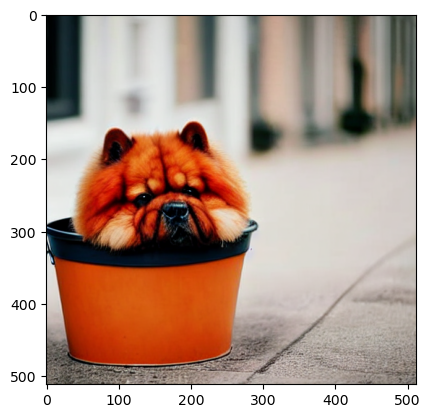

In [46]:
plt.imshow(image)